In [14]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import os
import re

plt.rc('axes', labelsize=30)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=30)    # fontsize of the tick labels
plt.rc('ytick', labelsize=30)    # fontsize of the tick labels

pol = ['../ucbopt_performance_sm220u_2_c220g1_2/results/cilantrologs/',
      '../ucbopt_performance_sm220u/results/cilantrologs/',
      '../ucbopt_performance_sm220u_1_c220g1_4/results/cilantrologs/']

TIME_ELAPSED = 'time_elapsed'
ALLOC_PER_UNIT_LOAD = 'alloc_per_unit_load'
EVENT_TIME_PERIOD = 'event_time_period'
EVENT_START_TIME = 'event_start_time'
EVENT_END_TIME = 'event_end_time'
P99 = 'p99'
AVG_LATENCY = 'avg_latency'
CUM_P99 = 'cum_p99'
CUM_AVG_LATENCY = 'cum_avg_latency'
LOAD = 'load'

deploys = ['root--consul', 'root--frontend', 'root--geo', 'root--jaeger', 'root--memcached-profile', 
           'root--memcached-rate', 'root--memcached-reserve', 'root--mongodb-geo', 
           'root--mongodb-profile', 'root--mongodb-rate', 'root--mongodb-recommendation', 
           'root--mongodb-reservation', 'root--mongodb-user', 'root--profile', 'root--rate', 
           'root--recommendation', 'root--reservation', 'root--search', 'root--user']

In [15]:
def convert_to_ms(s):
    # Regular expression to match numbers and units
    pattern = r'(\d+(?:\.\d+)?)\s*([μusm]?[sS])'

    # Match numbers and units using regular expression
    match = re.match(pattern, s)
    
    if match:
        # Extract number and unit
        number = float(match.group(1))
        unit = match.group(2).lower()

        # Convert to milliseconds
        if unit in ['μs', 'us']:
            return number * 0.001
        elif unit == 's':
            return number * 1000
        else:
            return number
    else:
        return None
    
def ecilantrologs(s):
    return int((s.split("-")[1]).split('.')[0])

def getDefaultRet(p):
    ret = []
    dfiles1 = [f for f in os.listdir(p)]
    #dfiles1 = sorted(dfiles1, key=ecilantrologs)
    for sd in dfiles1:
        with open(f"{p}/{sd}") as f:
            data = f.read()
        curr_data = {}
        if 'nan' in data:
            continue
        for l in data.split('\n'):
            if 'Latency' in l and '%' in l:
                #print(f"{p}/{sd}")
                #output = [s.strip() for s in l.split('  ') if s]
                output = re.split(r'\s+', l.strip())
                #print(f"{p}/{sd} {output}")
                avglat = float(convert_to_ms(output[1]))
                p99lat = float(convert_to_ms(output[3]))
                curr_data[P99] = p99lat*1000.0
                curr_data[AVG_LATENCY] = avglat*1000.0
            elif 'event_start_time' in l:
                curr_data[EVENT_START_TIME] = float(l.split(':')[1])
            elif 'event_end_time' in l:
                curr_data[EVENT_END_TIME] = float(l.split(':')[1])
                curr_data[EVENT_TIME_PERIOD] = curr_data[EVENT_END_TIME] - curr_data[EVENT_START_TIME]
            elif 'root--' in l:
                deps = eval(l)
                for d in deploys:
                    curr_data[d] = deps[d]
        ret.append(curr_data)
        #print(curr_data)
    ret.sort(key= lambda elem: elem['event_start_time'])
    exp_start_time = ret[0]['event_start_time']
    cum_p99_sum = 0
    cum_avg_lat_sum = 0
    for idx, elem in enumerate(ret):
        elem[TIME_ELAPSED] = elem[EVENT_START_TIME] - exp_start_time
        elem['idx'] = idx
        cum_p99_sum += elem[P99]
        cum_avg_lat_sum += elem[AVG_LATENCY]
        elem[CUM_P99] = cum_p99_sum / (idx + 1)
        elem[CUM_AVG_LATENCY] = cum_avg_lat_sum / (idx + 1)
    return ret

def getRet(p):
    df = pd.read_csv(p, index_col=0)
    ret = []
    for _, row in df.iterrows():
        curr_data = {EVENT_TIME_PERIOD: row['event_end_time'] - row['event_start_time'],
                             P99: row['p99'],
                             AVG_LATENCY: row['avg_latency'],
                             EVENT_START_TIME: row['event_start_time'],
                             EVENT_END_TIME: row['event_end_time'],
                            }
        deps = eval(row['allocs'])
        sumd = 0
        for d in deploys:
            curr_data[d] = deps[d]
            sumd = sumd + deps[d]
        #print(f"sumd = {sumd}")
            
        ret.append(curr_data)
    ret.sort(key= lambda elem: elem['event_start_time'])
    exp_start_time = ret[0]['event_start_time']
    cum_p99_sum = 0
    cum_avg_lat_sum = 0
    for idx, elem in enumerate(ret):
        elem[TIME_ELAPSED] = elem[EVENT_START_TIME] - exp_start_time
        elem['idx'] = idx
        cum_p99_sum += elem[P99]
        cum_avg_lat_sum += elem[AVG_LATENCY]
        elem[CUM_P99] = cum_p99_sum / (idx + 1)
        elem[CUM_AVG_LATENCY] = cum_avg_lat_sum / (idx + 1)
    return ret

361
361
361
361
359
359
24870000.0


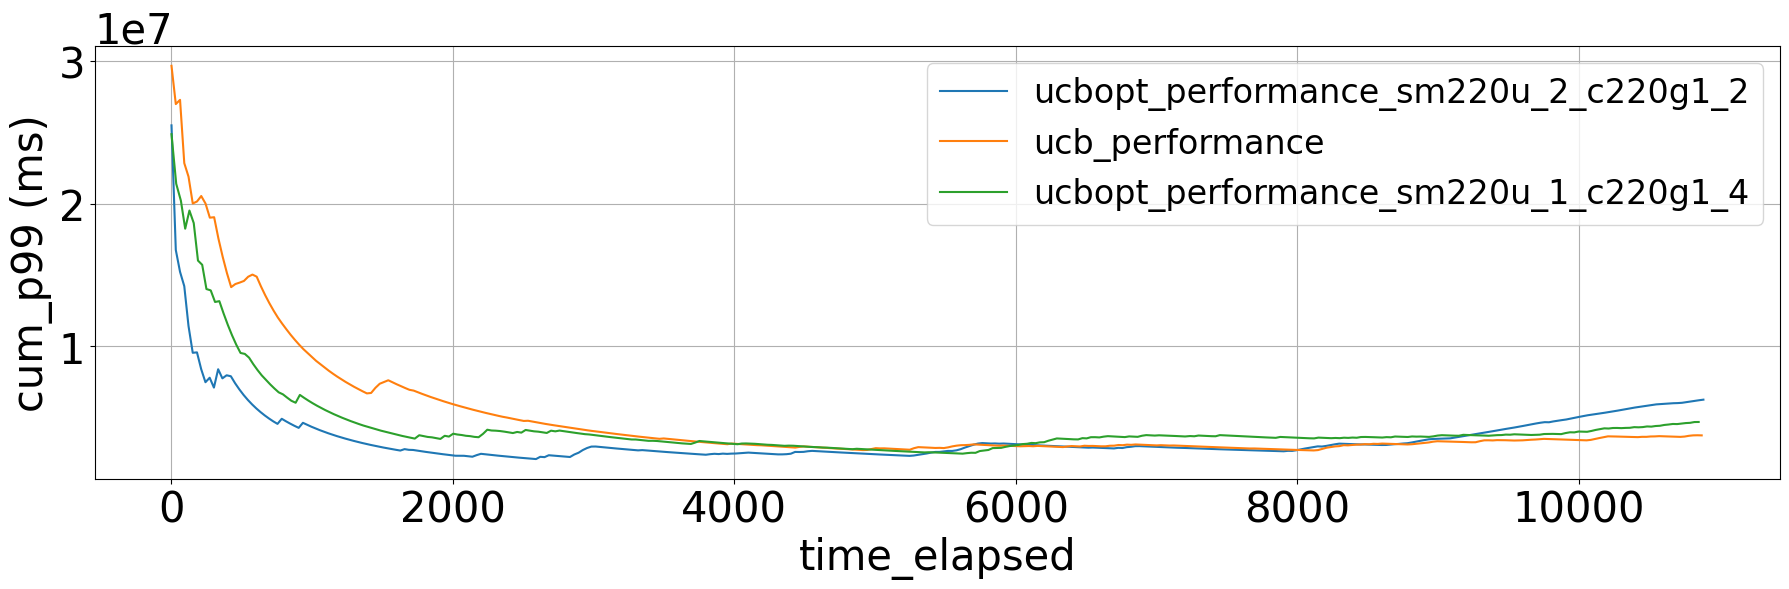

In [16]:
plt.rcParams['figure.figsize'] = 18, 6

## Graph from Cilantro paper

rets = {}
rets['ucbopt_performance_sm220u_2_c220g1_2'] = getDefaultRet(pol[0])
rets['ucb_performance'] = getDefaultRet(pol[1])
rets['ucbopt_performance_sm220u_1_c220g1_4'] = getDefaultRet(pol[2])

fig, ax = plt.subplots(1, 1)

for k, v in rets.items():    
    y_vals = [elem[CUM_P99] for elem in v]
    x_vals = [elem[TIME_ELAPSED] for elem in v]

    print(len(x_vals))
    print(len(y_vals))

    ax.errorbar(x_vals, y_vals, label=f"{k}")
    
ax.set_xlabel(f"{TIME_ELAPSED}")
ax.set_ylabel(f"{CUM_P99} (ms)")
print(y_vals[0])
#ax.set_ylim(0, 30000000)
#ax.set_xlim(0, 11000)
ax.grid(True)
ax.legend(fontsize=24)
plt.tight_layout()
plt.show()

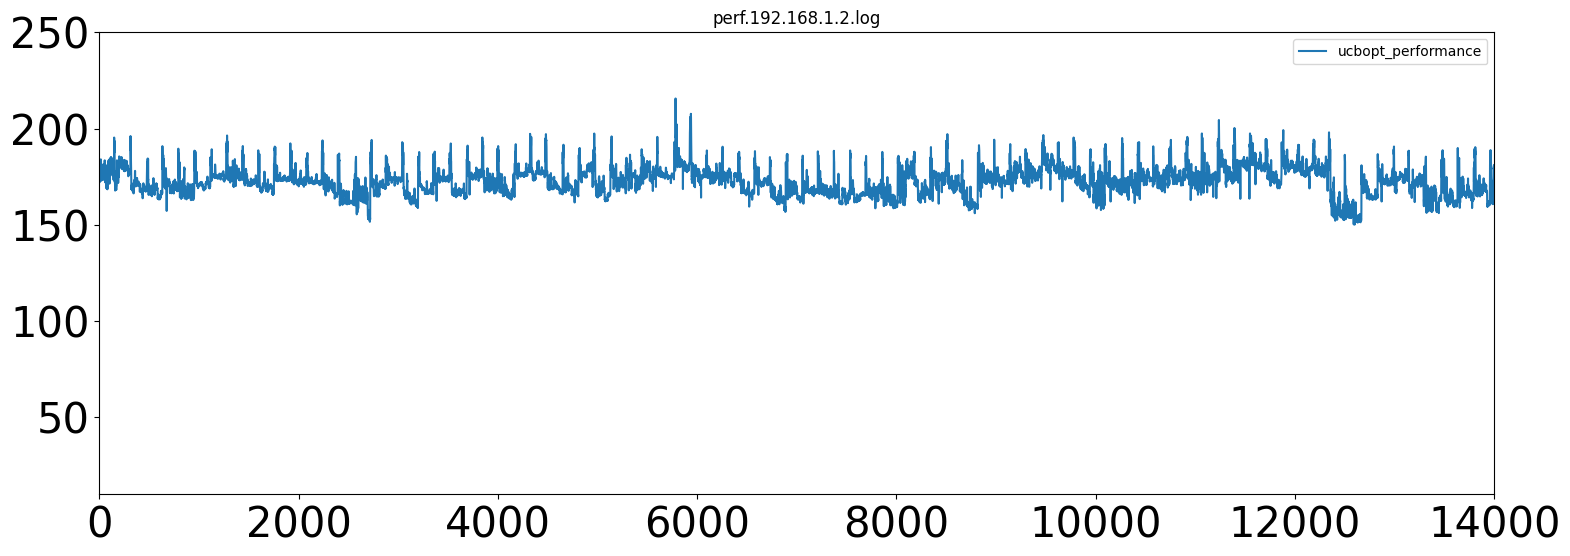

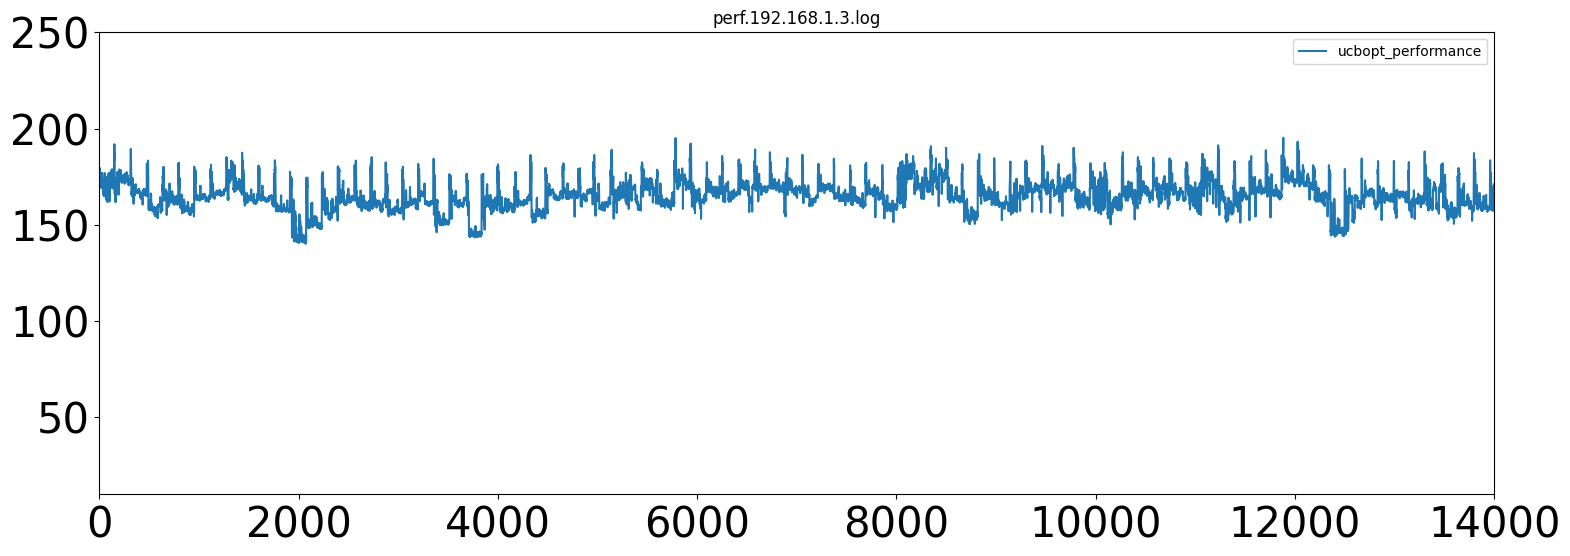

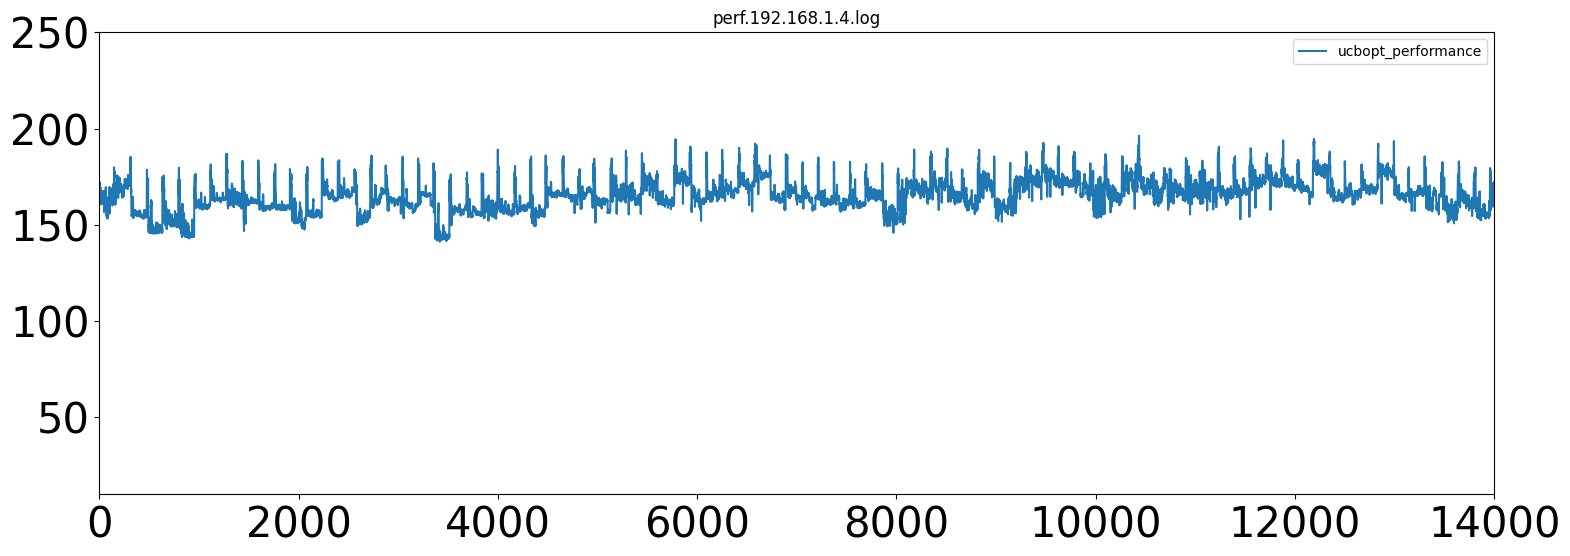

In [10]:
def getJoules(name):
    with open(name) as f:
        data = f.read()
    arr = []
    for l in data.split('\n'):
        try:
            arr.append(float(l.split(',')[1]))
        except:
            continue
    return arr
        
for name in ['perf.192.168.1.2.log', 'perf.192.168.1.3.log', 'perf.192.168.1.4.log']:
    arr = getJoules(f'../ucbopt_performance_sm220u/results/{name}')
    df = pd.DataFrame()
    df['pkg'] = arr
    ax = df.plot(y='pkg', kind='line', title=f"{name}", ylim=[10, 250], xlim=[0,14000], label='ucbopt_performance')   
    


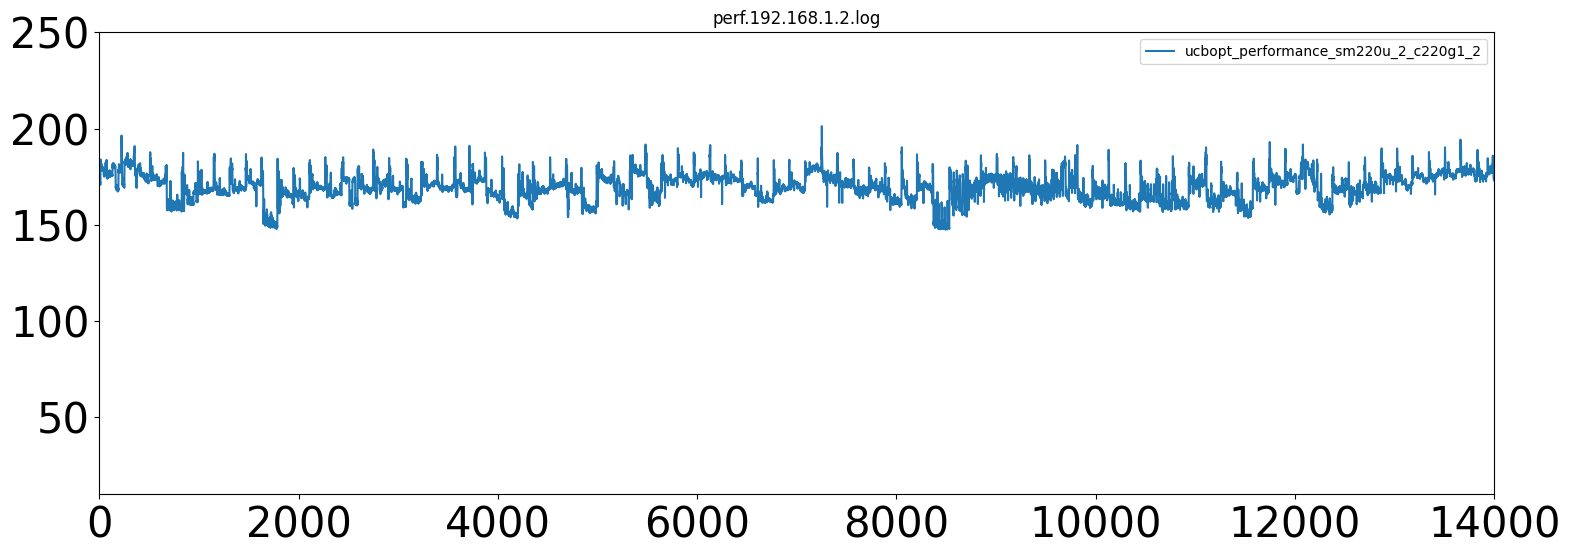

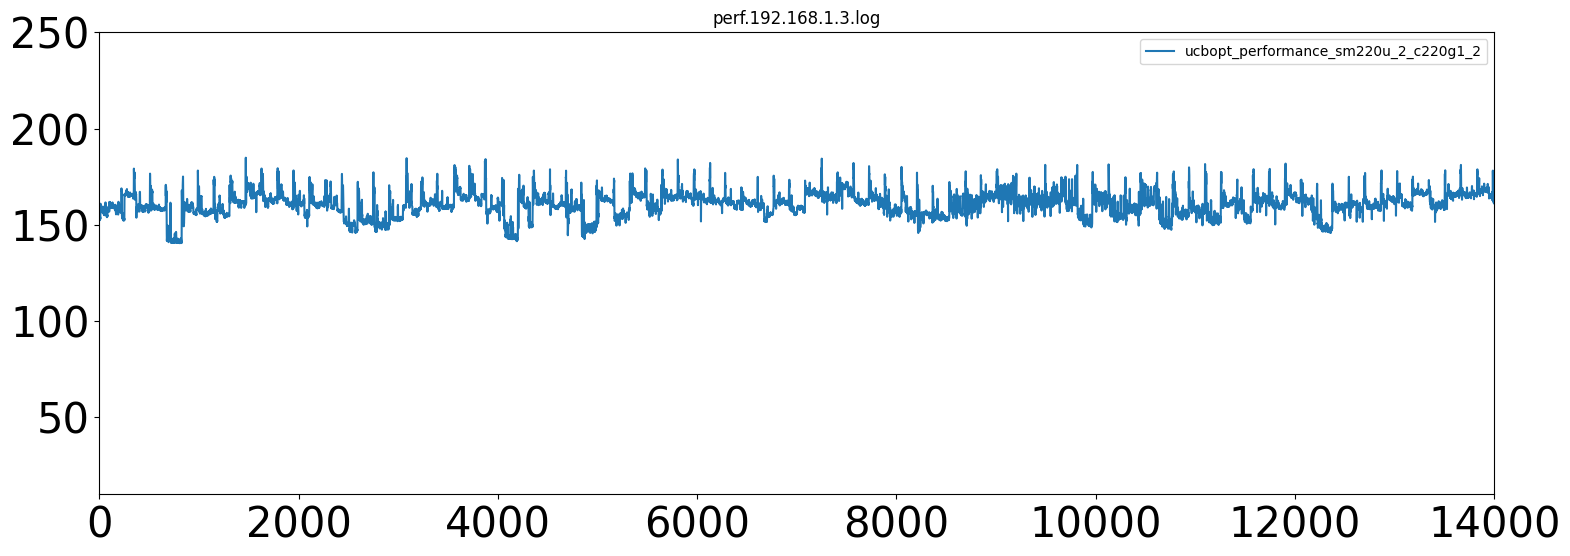

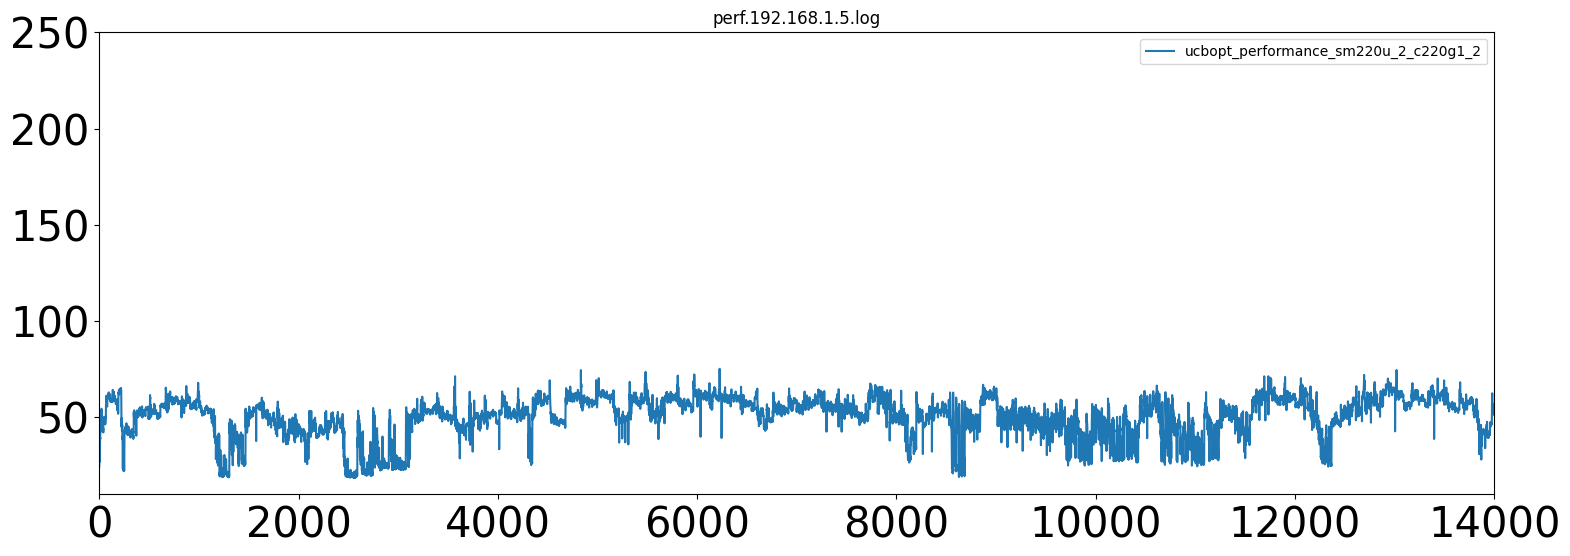

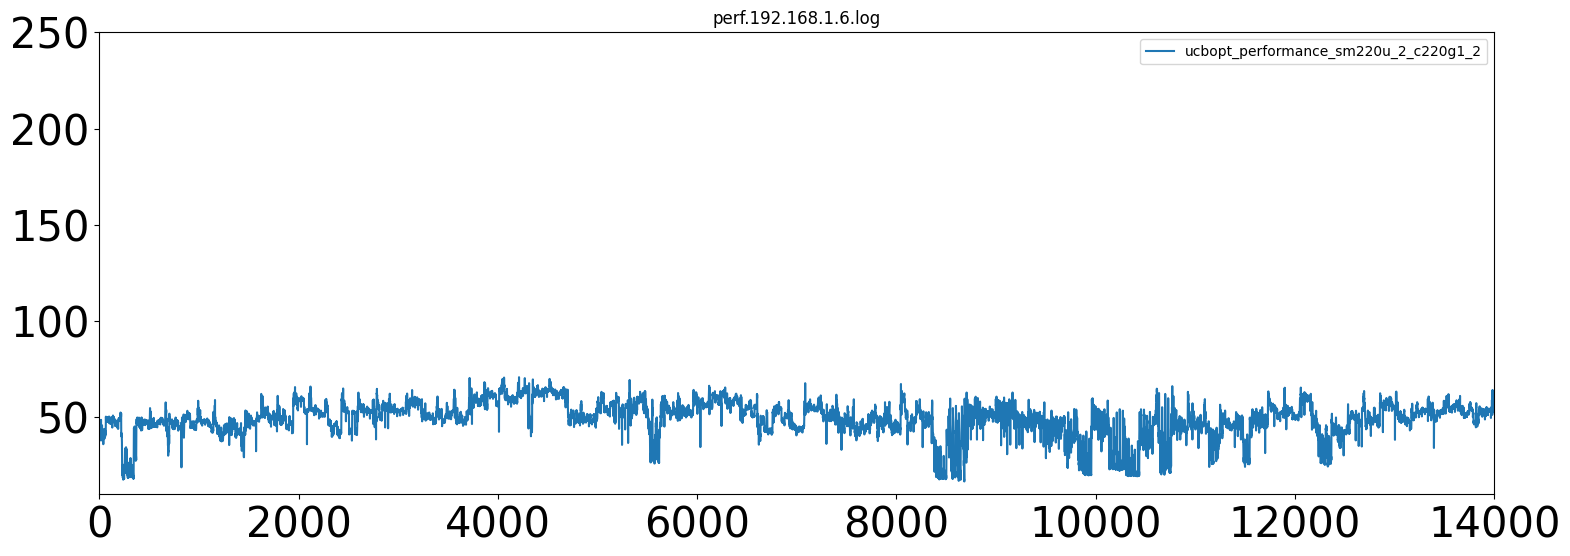

In [17]:
for name in ['perf.192.168.1.2.log', 'perf.192.168.1.3.log', 'perf.192.168.1.5.log', 'perf.192.168.1.6.log']:
    arr = getJoules(f'../ucbopt_performance_sm220u_2_c220g1_2/results/{name}')
    df = pd.DataFrame()
    df['pkg'] = arr
    ax = df.plot(y='pkg', kind='line', title=f"{name}", ylim=[10, 250], xlim=[0,14000], label='ucbopt_performance_sm220u_2_c220g1_2')   

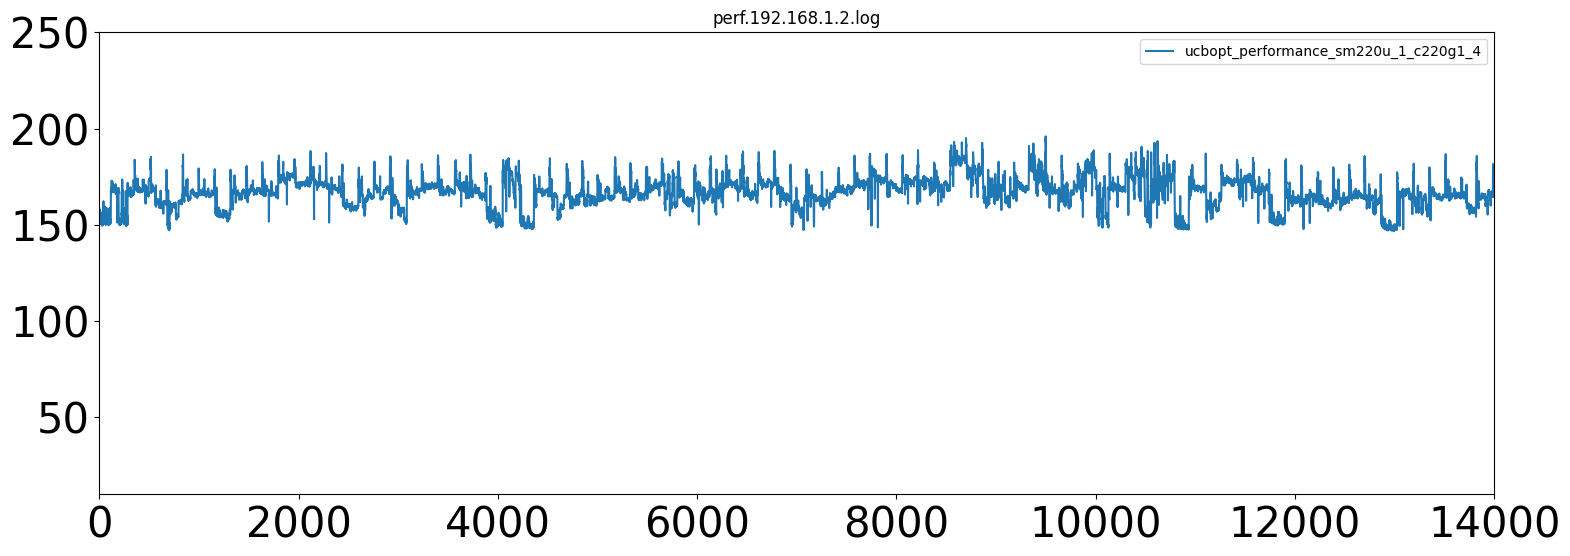

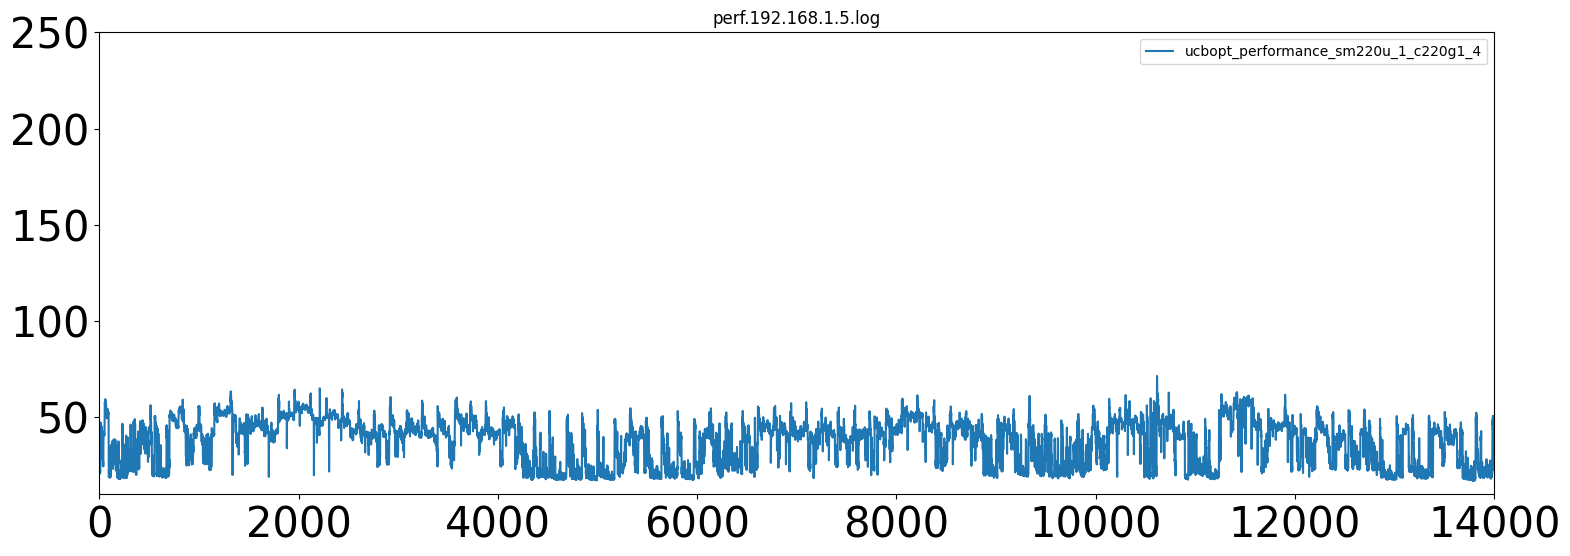

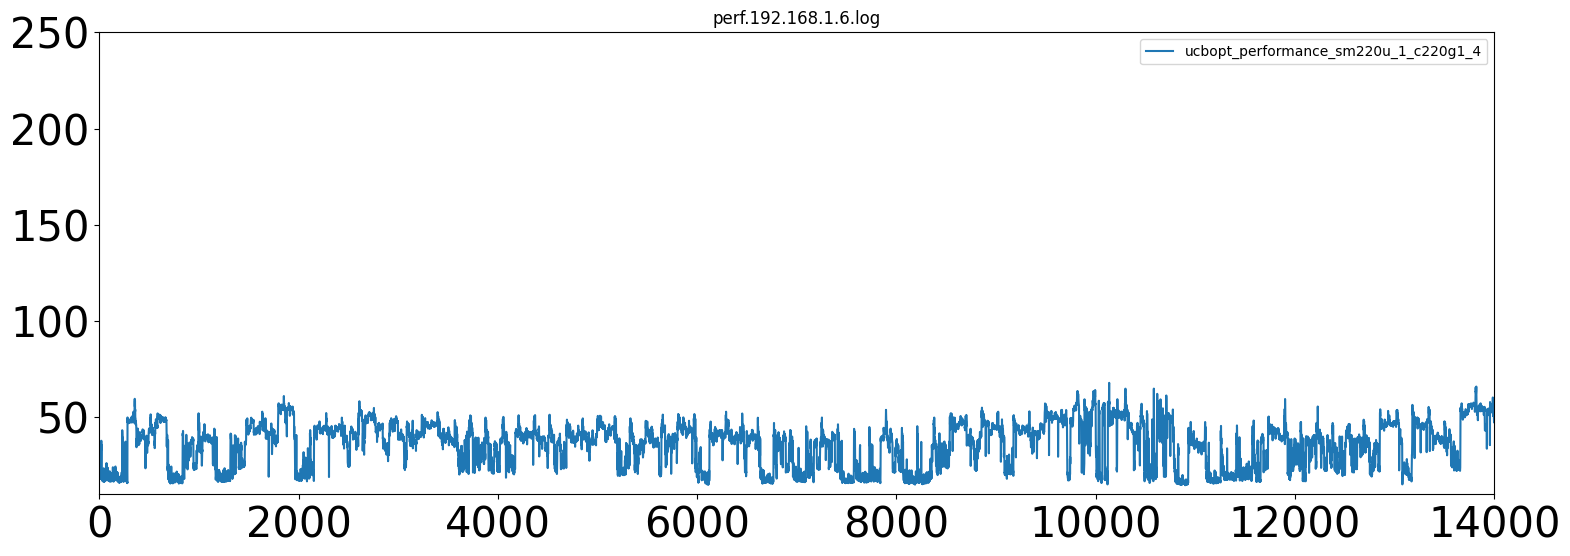

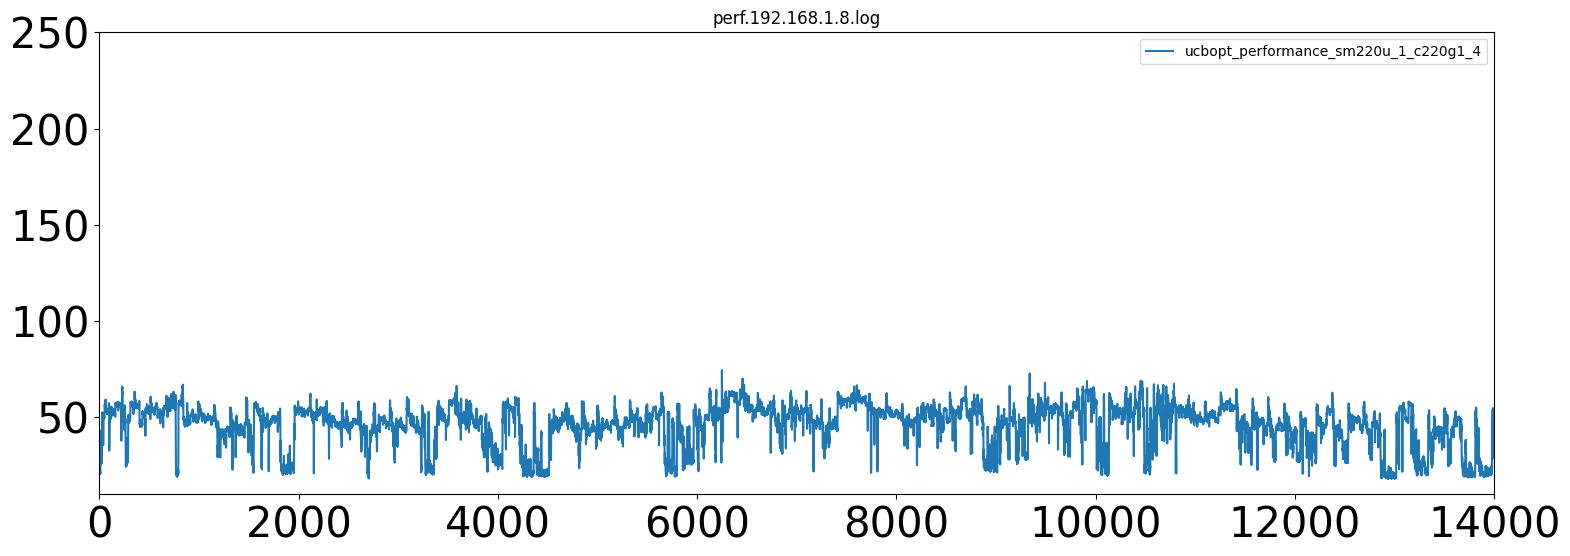

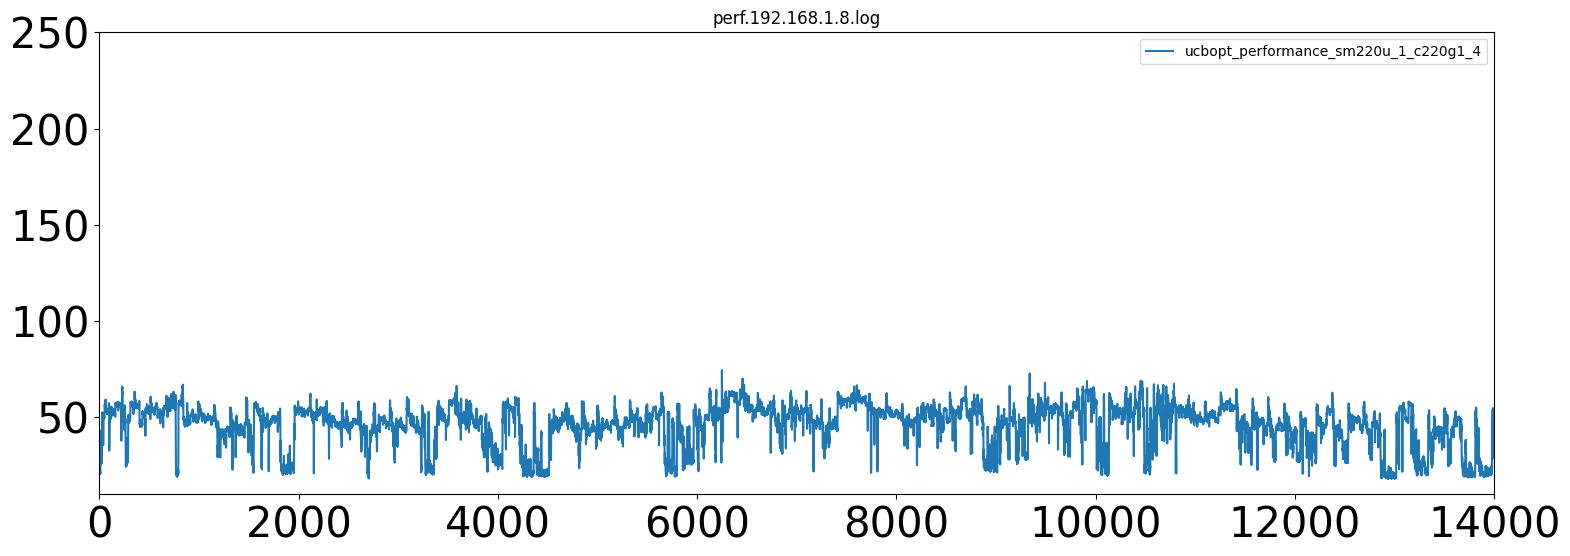

In [18]:
for name in ['perf.192.168.1.2.log', 'perf.192.168.1.5.log', 'perf.192.168.1.6.log', 'perf.192.168.1.8.log', 'perf.192.168.1.8.log']:
    arr = getJoules(f'../ucbopt_performance_sm220u_1_c220g1_4/results/{name}')
    df = pd.DataFrame()
    df['pkg'] = arr
    ax = df.plot(y='pkg', kind='line', title=f"{name}", ylim=[10, 250], xlim=[0,14000], label='ucbopt_performance_sm220u_1_c220g1_4')   